## Final Project Submission – Revision

* Student name: Greg Osborne
* Student pace: self paced / part time
* Scheduled project review date/time: 8/2/22
* Instructor name: Clause Fried
* Blog post URL: https://medium.com/@gregosborne

# Stakeholder: Maple Homes
# Problem: Maximize Salesmen Productivity
Real estate company Maple Homes employs several salesmen who are paid a commission for each of home they sell. As is customary for salesman, the commission is a percentage of the sale price. Salesmen, like all of us, only have so much time. How do they know which houses will yield the highest prices? What should they look for? What are three independent variables to look for in a home that will yield a high sale price, and thus a higher commission?

Maple Homes contracted FurPig industries to analyze county home sales data and give three recommendations to answer these questions.

# Functions
Pandas libraries.

In [1]:
#DataFrames and computation
import pandas as pd
import numpy as np

#Statsmodels for OLS modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms


#For plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import scipy.stats as stats

#To draw linear regression lines
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#For combinations
from itertools import product

#Setting DataFrame Display settings
pd.set_option("display.max_columns", None)

### Ordinary Least Squares Model, Histogram & Scatterplot functions

I will run a lot of models, and plot many histograms and scatterplots, so I will write a few functions to make the process easier.

In [2]:
#This function creates a model from a Pandas DataFrame and a list of variables
#to include. Price will be the dependent variable unless otherwise
#specified.
def make_model(mod, lst, Ya = 'price'):
    #Y-axis
    outcome = Ya
    #The factors that go into the model
    predictors = mod[lst]
    #Putting the string formula together
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    
    #The outcome
    return ols(formula=formula, data=mod).fit()

This function performs a log tranformation on the specified columns.

In [3]:
#This logs all the independent variables in the data.
def log_data(df, var,keep=False):
    #This variable will keep the order the same as the original DataFrame.
    order = df.columns
    #Creates an empty DataFrame to add to
    df_log = pd.DataFrame()
    #Column names
    new_col = []
    
    #This creates the final DataFrame, replacing the original values with the
    #logged values where specified
    for i in range(len(order)):
        if order[i] not in var:
            df_log[order[i]] = df[order[i]]
        else:
            new_col.append(order[i] + '_log')
            df_log[order[i] + '_log'] = df[order[i]].map(lambda x : np.log(x))
    
    #This alternate option keeps the unlogged data and adds the logged data
    #to the end of the DataFrame.
    if keep == True:
        df_new = df.copy()
        for col in new_col:
            df_new[new_col] = df_log[new_col]
        return df_new
    return df_log

The following functions normalizes data using min/max.

In [4]:
#This performs a min-max scaling of all independent variables in the data.
def scale_data(df,var,keep=False):
    #This variable will keep the order the same as the original DataFrame.
    order = df.columns
    #Creates an empty DataFrame to add to
    df_scale = pd.DataFrame()
    #Column names
    new_col = []
    
    #This creates the final DataFrame, replacing the original values with the
    #normalized values where specified
    for i in range(len(order)):
        if order[i] not in var:
            df_scale[order[i]] = df[order[i]]
        else:
            mn = df[order[i]].min()
            mx = df[order[i]].max()
            new_col.append(order[i] + '_scale')
            df_scale[order[i] + '_scale'] = df[
                order[i]].map(lambda x : (x-mn)/(mx-mn))
            
    #This alternate option keeps the non-normalized data and adds the
    #normalized data to the end of the DataFrame.
    if keep == True:
        df_new = df.copy()
        for col in new_col:
            df_new[new_col] = df_scale[new_col]
        return df_new
    return df_scale

The following function renames column names to be more aesthetically pleasing.

In [5]:
#Formats a list of variable names.
def rename_var(var_lst):
    #This is a mega list that formats all the column headings to be more 
    #aesthetically Pleasing.
    rename_var = {'price':'Price','bedrooms' : 'Bed', 'bathrooms' : 'Bath',
        'sqft_living': 'SF Liv', 'grade' : 'Grade',
        'sqft_lot' : 'SF Lot','floors': 'Floors',
        'waterfront': 'WF' ,'condition': 'Cond',
        'yr_built' : 'Yr', 'residuals' :'Residuals',
        'fitted_values' : 'Fitted Values',
        'bedrooms_log' : 'Log(Bed)', 'bathrooms_log' : 'Log(Bath)',
        'sqft_living_log': 'Log(SF Liv)', 'grade_log' : 'Log(Grade)',
        'sqft_lot_log' : 'Log(SF Lot)','floors_log': 'Log(Floors)',
        'waterfront_log': 'Log(WF)' ,'condition_log': 'Log(Cond)',
        'yr_built_log' : 'Log(Yr)',
        'bedrooms_scale' : 'Norm Bed','bathrooms_scale':'Norm Bath',
        'sqft_living_scale':'Norm SF Liv','grade_scale':'Norm Grade',
        'sqft_lot_scale':'Norm SF Lot','floors_scale':'Norm Floors',
        'waterfront_scale': 'Norm WF' ,'condition_scale':'Norm Cond',
        'yr_built_scale' : 'Norm Yr'}
    #An empty list to put the replaced column names
    renamed = []
    
    for var in var_lst:
        #This if statement was added as a way to allow functions with
        #different variables to still be used despite the columns not 
        #being listed in the dictionary renamed.
        if var not in rename_var:
            return var_lst
        #Renames the variables
        else:
            renamed.append(rename_var[var])
    return renamed

This function returns a string to easily identify which variables were used in the current model iteration.

In [6]:
#This returns a list of strings that identify the variables used in that
#row's model. It is used as an easy way to identify the included
#variables for that iteration of the model
def model_variables(lst):
    fv = rename_var(lst) #fv = fomatted variable
    #For a single variable
    if len(fv) == 1:
        text = f'{fv[0]}'
        return text
    
    #Two variables
    elif len(fv) == 2:
        text = f'{fv[0]} & {fv[1]}'
        return text
    
    #Three variables
    text = f'{fv[0]}, {fv[1]}, {fv[2]}'
    i = 3
    #Variables greater than three
    while i < len(fv):
        text = text + f', {fv[i]}'
        i += 1
    return text

This renames columns when they become coefficients for the model.

In [7]:
#This formats the DataFrame's column names for better aesthetics.
def format_df(df, var):
    #This is for the stats block. It properly identifies the columns as
    #coefficients
    rename_coefficients = {'bedrooms' : 'Bed Coef', 'bathrooms' : 'Bath Coef',
        'sqft_living': 'SF Liv Coef', 'grade' : 'Grade Coef',
        'sqft_lot' : 'SF Lot Coef','floors': 'Floors Coef',
        'waterfront': 'WF Coef' ,'condition': 'Cond Coef',
        'yr_built' : 'Yr Coef',
        'bedrooms_log' : 'Log(Bed) Coef', 'bathrooms_log' : 'Log(Bath) Coef',
        'sqft_living_log': 'Log(SF Liv) Coef', 'grade_log' : 'Log(Grade) Coef',
        'sqft_lot_log' : 'Log(SF Lot) Coef','floors_log': 'Log(Floors) Coef',
        'waterfront_log': 'Log(WF) Coef' ,'condition_log': 'Log(Cond) Coef',
        'yr_built_log' : 'Log(Yr) Coef',
        'bedrooms_scale' : 'Norm Bed Coef','bathrooms_scale':'Norm Bath Coef',
        'sqft_living_scale':'Norm SF Liv Coef','grade_scale':'Norm Grade Coef',
        'sqft_lot_scale':'Norm SF Lot Coef','floors_scale':'Norm Floors Coef',
        'waterfront_scale': 'Norm WF Coef' ,'condition_scale':'Norm Cond Coef',
        'yr_built_scale' : 'Norm Yr Coef'}
    
    #Setting all numerical values to floats
    floats = list(df.iloc[:,1:].columns)
    for obj in floats:
        df[obj] = df[obj].astype(float)

    #Formatting the numbers to be aesthetically pleasing.
    df['R²'] = df['R²'].map('{:.3f}'.format)
    df['P-value'] = df['P-value'].map('{:.1f}'.format)
    df['Intercept'] = df['Intercept'].map('{:.1f}'.format)
    for v in list(df.iloc[:,6:].columns):
        if v in df.columns:
            df[v] = df[v].map('{:.1f}'.format)
            
    #Setting all numerical values to floats (again)
    floats = list(df.iloc[:,1:].columns)
    for obj in floats:
        df[obj] = df[obj].astype(float)

    #Setting special rows to their specific type.
    df['Neg Coef?'] = df['Neg Coef?'].astype(bool)
    df['Num Variables'] = df['Num Variables'].astype(int)

    #Renaming the columns
    df = df.rename(columns = rename_coefficients)
    return df

### Stats Block
I needed a way to quickly compare different models, so I came up with this stats block that gives the variables used in the model, number of variables, R², P-value, whether the model includes negative coefficients, intercept, skewness, kurtosis, Jarque-Bera, Breush-Pagan F-Value, condition  number, and variable coefficients. 

In [8]:
#This creates the DataFrame with the included model's pertinent statistics.
#This creates the Stats Block.
def model_stats(df,var, model_return=False):
    #A DataFrame to sort the outcomes and make it look pretty.
    dfr_col = ['Model Variable(s)', 'Num Variables','R²','P-value','Neg Coef?',
               'Intercept','Skewness', 'Kurtosis',
               'Jarque-Bera', 'Breush-Pagan F-Value', 'Cond. No']
    dfr = pd.DataFrame(columns = dfr_col)
    neg = False
    
    #Running StatsModels
    m = make_model(df,var)
    
    #Testing to see if this model meets the requirements. The function returns 
    #an empty DataFrame if it does not.
    d = dict(m.params)
    if m.rsquared <= 0.0:
        return dfr
    for v in var:
        if d[v] < 0:
            neg = True
        
    #Building the DataFrame to return.
    d.update({'Model Variable(s)' : model_variables(var),
              'Num Variables' : len(var),
              'R²' : m.rsquared,'P-value' : m.f_pvalue,
              'Neg Coef?' : neg,
              'Skewness' : m.summary2().tables[2].iloc[2,1],
              'Kurtosis' : m.summary2().tables[2].iloc[3,1],
              'Jarque-Bera' : m.summary2().tables[2].iloc[1,3],
              'Breush-Pagan F-Value' : sms.het_breuschpagan(
                  m.resid, m.model.exog)[2],
              'Cond. No' : m.summary2().tables[2].iloc[3,3]})
    dfr = dfr.append(d,ignore_index = True)
    
    #Formatting the DataFrame to return.
    dfr = format_df(dfr,var)
    
    if model_return == False:
        return dfr
    else:
        return m, dfr

This function runs a model for each possible combination of variable given, with no transformations.

In [9]:
#This runs hundreds of models, with the specified number of variables per 
#model and returns the stats block.
def mega_models_no_trans(df,beg,end):
    
    #Variable declaration
    #Variable that keeps a list of the column names of each df iteration.
    check = []
    #Variables related to printing text to provide feedback to the user to 
    #ensure the function is still running.
    skip = False
    skip_count = 0
    discarded_models = 0
    cnt_var = 0
    cur_var = beg
    prev_len = 0
    #Creating an empty list of DataFrames (dfs) that I will use to build each
    #iteration of the DataFrames in the for loop below.
    dfs = [None,None,None,None,None,None,None,None,None]

    #Splitting the DataFrame parameter into individual DataFrames, each are the
    #same variable with all the applicable transformations.
    dep_df = df.iloc[:,0].copy()
    ind_df = df.iloc[:,1:].copy()
    
    #Creating the DataFrame with the columns in an order that makes sense.
    dfr_col = ['Model Variable(s)', 'Num Variables','R²','P-value','Neg Coef?',
               'Intercept','Skewness', 'Kurtosis',
               'Jarque-Bera', 'Breush-Pagan F-Value', 'Cond. No']
    for i in range(1,len(df.columns)):
        dfr_col.append(df.iloc[:,i].name)
    dfr = pd.DataFrame(columns=dfr_col)
    dfr = format_df(dfr, dfr_col)
    dfr['Neg Coef?'] = dfr['Neg Coef?'].astype(bool)
    
    #Creating dictionary of combinations. The key is the number of variables
    #per iteration, and the value is a list of which variables to include.
    num_var = dict(zip([0,1,2,3,4,5,6,7,8,9],
                  [[],[],[],[],[],[],[],[],[],[]]))
    for lst in product(range(2),repeat=9):
        num_var[sum(lst)].append(lst)
        
    #This for loop is the major work of this function. It creates a DataFrame
    #with pertinent information on different combinations of variables
    #specified in the parameters.
    for num in range(beg,end+1):
        #Prints feedback text so the user knows the program is running.
        cnt_var += 1
        print(f'Combos of {cur_var} variables ({cnt_var}/{end-beg+1}).')
        cur_var += 1
        
        #Resetting count variables related to each combination of variables
        model_count = 0
        skipped = 0
        
        #Calculating the total number of iterations for this combination of
        #variables.
        var_tot_iter = len(num_var[num])
        
        #This first for loop iterates through the combinations of which
        #variables to include in the current iteration.
        for vars_used in num_var[num]:
            i=0 #Specifies iteration of variable.
                
            #Checks if current iteration includes variables that I
            #previously learned are multicollinear. This portion of code
            #doesn't check for multicollinearity, but rather filters out
            #variables I previously tested positive for multicollinearity.
            if vars_used[2] == 1:
                if vars_used[1] == 1 or vars_used[7] == 1:
                    #This function returns True or False whether the 
                    #values are multicollinear.
                    skip=True
                    skipped += 1
                    var_tot_iter -= 1
                    continue
                            
            #This creates the list of DataFrames for this iteration.
            for var in vars_used:
                if var == 1:
                    dfs[i] = df.iloc[:,i+1].copy()
                    i+=1
                        
                #This creates the list to check if this iteration is a repeat.
                else:
                    dfs[i]=None
                    i+=1
                                    
            #This puts the gleaned variables together into one DataFrame.

            iter_df = pd.concat([dep_df,dfs[0],dfs[1],dfs[2],
                                 dfs[3],dfs[4],dfs[5],dfs[6],
                                 dfs[7],dfs[8],],axis = 1)
                
            #And finally, the program runs the iteration through 
            #StatsModels, and creates a DataFrame of the critical 
            #statistics (stats block).
            col = list(iter_df.iloc[:,1:].columns)
            dfr_temp = model_stats(iter_df,col)
            model_count += 1 #Counts a successfully created a model.
            skip=False #This iteration wasn't skipped.
                
            #The model_stats function will return a an empty DataFrame if
            #the model's data didn't meet certain requirements.
            if dfr_temp.empty:
                discarded_models += 1
                continue
                    
            #DataFrame statistics is now added to the DataFrame to return.
            dfr = dfr.append(dfr_temp, ignore_index=True)
    
        #Ending text to confirm the function performed correctly.
        print(f'Skipped {skipped} iterations due to multicollinearity.')
        new_len = len(dfr) - prev_len
        print(f'{discarded_models} models discarded due to low R².')
        print(new_len, 'Models met minimum requirements.')
        discarded_models = 0
        prev_len = len(dfr)
        print()
    print('There are a total of',len(dfr),'DataFrames that met requirements')
    #Organizing the DataFrame to return.
    dfr = dfr.sort_values('R²',ascending=False)
    dfr = dfr.reset_index(drop=True)
    return dfr

This creates a regression line to later be used with scatterplots. It can do so at the specified polynomial, though I didn't use that portion of the function in the final analysis.

In [10]:
#Creating regression line per the specified degree of polynomial.
def polynom_regression(df, var, Y_axis='price', deg=1):
    Y = df[Y_axis]
    X = pd.DataFrame(df[var])
    poly = PolynomialFeatures(deg)
    X_fin = poly.fit_transform(X)
    reg_poly = LinearRegression().fit(X_fin, Y)
    X_linspace = pd.DataFrame(np.linspace(0, X.max(), 500), columns=[var])
    X_linspace_fin = poly.fit_transform(X_linspace)
    y_poly_pred = reg_poly.predict(X_linspace_fin)
    Xs = reg_poly.predict(X_fin)
    X_pts = X_linspace[var].values.tolist()
    return X_pts, list(y_poly_pred), X_fin, Xs

This function draws a simple line given some Xs and Ys. During the analysis, I combined this function with a list of x and y datapoints gleaned from the final model. This is specifically tailored to the final model, as the waterfront value added matches the waterfront coefficient.

In [11]:
#Creates a simple line graph based on Xs and Ys.
def simple_line(Xs, Ys, xlabel = 'Nope', title = 'Nope', wf = 0):
    #Xs and Ys: The datapoints
    #xlabel: A label for the X-axis, skipped if "Nope"
    #title: A title for the graph, skipped if "Nope"
    #wf: whether to plot the same data while adding the Waterfront value
    fig, ax = plt.subplots()
    
    #Adds the waterfront line if wf = 1
    if wf == 1:
        wf_Ys = []
        for Y in Ys:
            wf_Ys.append(Y + 844.11078)
        plt.plot(Xs, wf_Ys, color='blue')
        
    #Plots the data
    plt.plot(Xs, Ys, color='red')
    
    #Plots the legend if wf data is used
    if wf == 1:
        ax.legend(['On a Waterfront','Not on a Waterfront'])
        
    #prints the xlabel and the ylabel
    if xlabel not in 'Nope':
        diff = np.max(Ys) - np.min(Ys)
        diff = "\${:,.0f}K".format(diff)
        if Ys[-1] < Ys[1]:
            diff = f'({diff})'
        diff_text = f'Range: \$0 to {diff}'
        xlabel = xlabel + '\n' + diff_text + '\n' + 'Waterfront adds \$844K'
    
        plt.xlabel(xlabel, size = 20)
    plt.ylabel('Price (USD)', size = 20)
    
    #Setting up the Y-axis tick marks
    current_values = ax.get_yticks()
    current_values[:]=current_values[:]
    ax.set_yticklabels(['${:,.0f}K'.format(x)
                        for x in current_values], size = 15)
    
    #and finally the title
    plt.xticks(fontsize = 15)
    if title not in 'Nope':
        plt.title(title, size = 20)
    ;

This prints a scatterplot and histogram side by side. 

In [12]:
#Prints a scatterplot and histogram, side by side.
def scatter_hist(df, var, title='auto'):
    #Creating the tile.
    renamed = rename_var([var])
    renamed = renamed[0]
    if title == 'auto':
        title = f'{renamed}'
    subtitle_lst = ['Scatterplots\nwith Regression Line',
                    'Histograms\nwith Kernal Density Estimation']
    
    #Creates the single variable model and sets R², which is the
    #R-squared value
    mod = make_model(df,[var])
    r2 = mod.rsquared
    r2_t = '{:.3f}'.format(r2)
    r2_text = f'R² value for {renamed} individually: {r2_t}'
    
    #Gets the data to draw the regression line for the 
    #scatterplot
    x_reg, y_reg, x_fin_reg, Xs_reg  = polynom_regression(df, var)
    
    #Setting plot positions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    plt.suptitle(title, size = 20)
    plt.subplots_adjust(top=0.83)
    
    #Plotting scatterplot on the left.
    df.plot(kind='scatter', x=var, y='price', ax=axes[0], alpha=0.4)
    axes[0].plot(x_reg, y_reg, color='red')
    axes[0].set_xlabel(renamed,size=15)
    axes[0].set_ylabel('Price',size=15)
    axes[0].set_title(subtitle_lst[0], size = 20)
    if df[var].min() > 1800:
        axes[0].set_xlim(df[var].min() - 10, df[var].max() + 10)
    
    #Plotting histogram on the right.
    df[var].plot.hist(density=True, ax=axes[1])
    df[var].plot.kde(ax=axes[1], ind=50)
    axes[1].set_ylabel('Density',size=15)
    axes[1].set_title(subtitle_lst[1], size = 20)
    
    #Printing the individual R² value
    plt.figtext(.12,-.05,r2_text,size = 20,ha='left')


This creates a series of scatterplots of variables from a DataFrame as long as you like it to be.

In [13]:
#This returns a number of scatterplots with the y-axis as price.
def scatter_plots(df, var, Yax = 'price',
                  ylabel = 'Price (USD)', title='auto', sub_message = 'Nope'):
    #Creating the tile.
    renamed = []
    for v in var:
        temp = rename_var([v])
        renamed.append(temp[0])
    if title == 'auto':
        title = 'Scatterplots with Regression Line'
    
    #This for loop creates the regression line for each scatterplot
    x_reg, y_reg, x_fin_reg, Xs_reg = [],[],[],[]
    for v in var:
        x_rg, y_rg, x_fin_rg, Xs_rg  = polynom_regression(df, v, Y_axis=Yax)
        x_reg.append(x_rg)
        y_reg.append(y_rg)
        x_fin_reg.append(x_fin_rg)
        Xs_reg.append(Xs_rg)
        
    #Setting plot positions for each row with two plots
    if len(var) != 1:
        num_rows = len(var) // 2
        fig, axes = plt.subplots(nrows=num_rows, ncols=2,
                                 figsize=(10,num_rows*5))
        plt.subplots_adjust(top=(num_rows*5-.85)/(num_rows*5))
        axe = axes.ravel()

    #Setting plot position for the last row and plotting it.
    if (len(var)) % 2 == 1:
        fig_odd, axes_odd = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        e = len(var)-1
        df.plot(kind='scatter', x=var[e], y=Yax, ax=axes_odd, alpha=0.4)
        axes_odd.plot(x_reg[e], y_reg[e],color='red')
        axes_odd.set_xlabel(renamed[e],size=15)
        axes_odd.set_ylabel(ylabel,size=15)
        if df[var[e]].min() > 1800:
            axes_odd.set_xlim(df[var[e]].min() - 10, df[var[e]].max() + 10)
    
    #Plot the title
    plt.suptitle(title,size=20)
    
    #Printing an optional sub message at the bottom.
    if 'Nope' not in sub_message:
        plt.figtext(.12,-.05,sub_message,size = 20,ha='left')

    if len(var) == 1:
        return

    #Plotting scatterplots
    for xcol, x_line, y_line, ax, t in zip(var, x_reg, y_reg, axe, renamed):
        df.plot(kind='scatter', x=xcol, y=Yax, ax=ax, alpha=0.4)
        ax.plot(x_line, y_line, color='red')
        ax.set_xlabel(t,size=15)
        ax.set_ylabel(ylabel,size=15)
        if df[xcol].min() > 1800:
            ax.set_xlim(df[xcol].min() - 10, df[xcol].max() + 10)
    ;

This creates a combo of a histogram and QQ-plot side by side.

In [14]:
#Creates a histogram next to a QQ-Plot.
def hist_qq(df, var, title='auto', sub_message = 'Nope'):
    #Creating the tile.
    renamed = rename_var([var])
    renamed = renamed[0]
    if title == 'auto':
        title = f'{renamed}'
    
    #Creating the gramatically correct subtitle
    if len(var) == 1:
        subtitle_lst = ['Histogram with\n Kernal Density Estimation',
                        'Q-Q Plot']
    else:
        subtitle_lst = ['Histograms with\n Kernal Density Estimation',
                        'Q-Q Plots']
        
    
    #Setting plot positions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    plt.suptitle(title, size = 20)
    plt.subplots_adjust(top=0.81)
    
    #Plotting histogram on the left.
    df[var].plot.hist(density=True, ax=axes[0])
    df[var].plot.kde(ax=axes[0], ind=500)
    axes[0].set_ylabel('Density',size=15)
    axes[0].set_title(subtitle_lst[0], size = 20)
    
    #Plot QQ Plot
    sm.graphics.qqplot(df[var], dist=stats.norm, line='45', 
                       fit=True, ax = axes[1])
    axes[1].set_ylabel('Sample Quantiles',size=15)
    axes[1].set_xlabel('Theoretical Quantiles',size=15)
    axes[1].set_title(subtitle_lst[1], size = 20)
    
    #Printing an optional sub message at the bottom.
    if 'Nope' not in sub_message:
        plt.figtext(.12,-.05,sub_message,size = 20,ha='left')
    
    ;

I wrote a single function to cover all four assumptions of linear regression

In [15]:
#This function plots the necessary graphs to test the linearity 
#assumptions.
def assumption(assump, df=1, mod=1, mod_stat=1, title='auto'):
    #Linearity assumption
    if assump == 1:
        scatter_plots(df,list(mod.params.index[1:]), title = title)
        return
    
    #Multicollinearity/Independence assumption
    if assump == 4:
        variables = ['price']
        for var in list(mod.params.index[1:]):
            variables.append(var)
        var_renamed = rename_var(variables)
        df_renamed = df.copy()
        for o, r in zip(variables, var_renamed):
            df_renamed.rename({o:r}, axis = 1, inplace = True)
        multicollinearity_test = df_renamed[var_renamed].corr()
        for c in multicollinearity_test.columns:
            multicollinearity_test[c] = multicollinearity_test[c].map(
            '{:.3f}'.format)
            
        cn = float(mod_stat['Cond. No'])
        message = 'Condition Number = ' + str(cn)
        plt.figure(figsize = (5,5))
        heat = sns.heatmap(df_renamed[var_renamed].corr(), center=0)
        heat.set_title(title,size=20)
        plt.figtext(.12,-.05,message,size = 20,ha='left');
        return multicollinearity_test
    
    #This is used in the last two linear regression assumptions
    residuals = pd.DataFrame()
    residuals['residuals'] = mod.resid
    
    #Normality assumption
    if assump == 2:
        jb = float(mod_stat['Jarque-Bera'])
        message = 'Jarque-Bera = ' + str(jb)
        hist_qq(residuals,'residuals', sub_message = message,
                title=title)
        return 
    
    #Homoscedasticity assumption
    if assump == 3:
        residuals['fitted_values'] = mod.fittedvalues
        fv = float(mod_stat['Breush-Pagan F-Value'])
        message = 'Breush-Pagan F-Value = ' + str(fv)
        scatter_plots(residuals,['fitted_values'],Yax = 'residuals',
              ylabel = 'Residuals',title = title,
              sub_message = message)
        return

This gets rid of a set number of outliers at the top or bottom of a dataset for each variable specified. It creates a modified version of my stats block with two extra columns that detail how many rows it removed per variable and how many total rows it removed.

In [16]:
#Removes a set number of outliers, high or low.
def remove_outliers(df, var, num, make_models = False,
                    head = True, mod_var = 0):
    #collection of index numbers that will be removed from the dataset.
    index_to_remove = set()
    
    #This for loop tests adds the index number for each removed row
    #to the index_to_remove variable
    for v in var:
        for i in list(df.sort_values(v, ascending = not head).head(num).index):
            index_to_remove.add(i)
    
    #This creates the returned Dataframe with the removed rows
    df_return = df.drop(index_to_remove)
    
    #If the user specifies it, this will create the modified stats block
    #with columns describing what was removed, and the model itself.
    #It's skipped if the user just wants the new dataset
    if make_models == True:
        if mod_var != 0:
            var = mod_var
        if 'price' in var:
            var.remove('price')
        mod, mod_stats = model_stats(df_return,var,True)
        mod_stats.insert(0, 'Dropped Rows', len(index_to_remove))
        mod_stats.insert(0, 'Peak Values Dropped Per Variable', num)
        return df_return, mod, mod_stats
    return df_return

### Review the Data
First, I must import the data and look at a few rows.

In [17]:
#importing the data
data = pd.read_csv('data/kc_house_data.csv')

#Dropping columns as specified by the client
columns_to_drop = ['date', 'view', 'sqft_above', 'sqft_basement', 
                   'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
                   'sqft_lot15']
data = data.drop(columns_to_drop,axis='columns')

#Plot the data
data

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987
...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,NO,Average,8 Good,2009
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,NO,Average,8 Good,2014
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,NO,Average,7 Average,2009
21595,291310100,400000.0,3,2.50,1600,2388,2.0,NaN,Average,8 Good,2004


I need to see what types of data are stored in each column. For this I'll run the info method.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  int64  
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  object 
 8   condition    21597 non-null  object 
 9   grade        21597 non-null  object 
 10  yr_built     21597 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.8+ MB


### Categorical Data
There are three columns that are not listed as numbers, but as objects. I need to see what kinds of values are in each of these columns. For this, I'll use value_counts and plot a histogram.

NO     19075
YES      146
Name: waterfront, dtype: int64


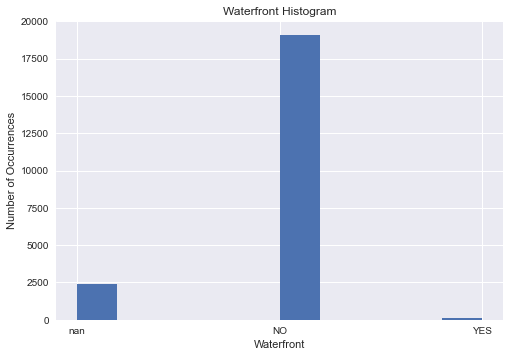

In [19]:
#Plot the value count
print(data['waterfront'].value_counts())

#Plot a histogram
plt.title('Waterfront Histogram')
plt.ylabel('Number of Occurrences')
plt.xlabel('Waterfront')
plt.hist(data['waterfront']);

Regarding the Waterfront column, 11% of the data is missing a waterfront value. 11% is a lot of useful data. This data came from home listings, and nobody would fail to mention that their home is on a waterfront since that significantly increases its value. Knowing that, and the fact that less than 1% of the entire dataset is listed as located on a waterfront, I'm going to change all those NANs to NOs, and rerun the count and histogram. 

NO     21451
YES      146
Name: waterfront, dtype: int64


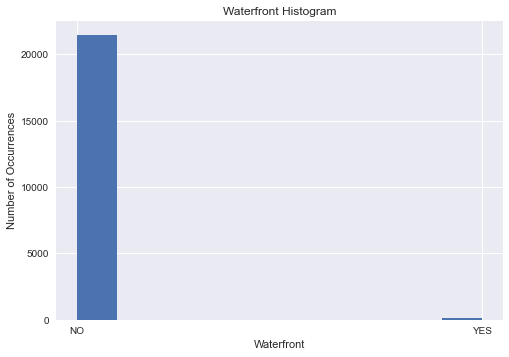

In [20]:
#Convert the NaNs to "NO"
data.loc[data['waterfront'].isna(),'waterfront'] = 'NO'

#Plot value count and histogram again
print(data['waterfront'].value_counts())
plt.title('Waterfront Histogram')
plt.ylabel('Number of Occurrences')
plt.xlabel('Waterfront')
plt.hist(data['waterfront']);

Since the waterfront data is binary already, I'll turn it into a simple one or zero. This will also make the column integers.

In [21]:
#Convert yes and no to binary, 0 and 1
data['waterfront'].replace({'NO':0,'YES':1},inplace=True)

data['waterfront'].value_counts()

0    21451
1      146
Name: waterfront, dtype: int64

A few other stats about WaterFront.

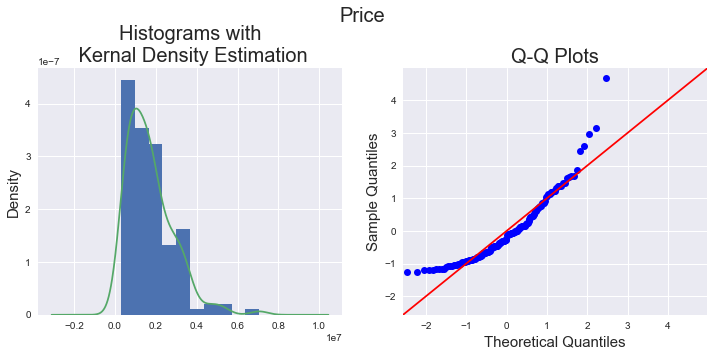

In [22]:
#Waterfront price distribution
hist_qq(data.loc[data['waterfront']==1],'price')

In [23]:
#How many waterfront homes are in the data?
len(data.loc[data['waterfront']==1])

146

In [24]:
#The average price of waterfront homes in King County
avg_wf_price = data.loc[data['waterfront']==1]['price'].mean()
avg_wf_price = '${:,.0f}'.format(avg_wf_price)
avg_wf_price

'$1,717,215'

In [25]:
#A percentage of waterfront homes in King County
perc = len(data.loc[
    data['waterfront']==1]['price'])/len(data)*100
perc = '{:,.2f}%'.format(perc)
perc

'0.68%'

There are one-hundred-forty-six homes on the waterfront in King County, and their average sale price is \$1,717,215. Only 0.7\% of homes in King county are on a waterfront.

Now to check the condition column.

3 Average      14020
4 Good          5677
5 Very Good     1701
2 Fair           170
1 Poor            29
Name: condition, dtype: int64


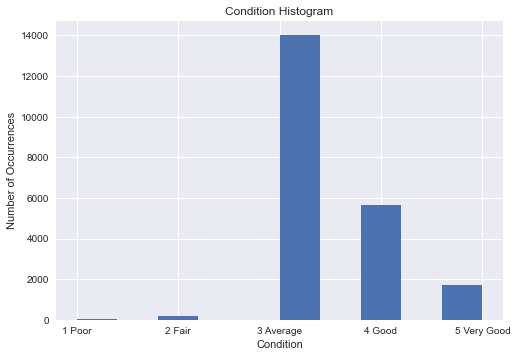

In [26]:
#Renaming the columns to show the numbers with the counts and histogram.
change_numerical_condition = {'Poor' : '1 Poor', 'Fair' : '2 Fair',
                              'Average' : '3 Average', 'Good' : '4 Good',
                              'Very Good' : '5 Very Good'}  
data['condition'] = data['condition'].replace(change_numerical_condition)

#The count
print(data['condition'].value_counts())

#The histogram
plt.title('Condition Histogram')
plt.ylabel('Number of Occurrences')
plt.xlabel('Condition')
plt.hist(data['condition'].sort_values());

The last object column is grade.

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64


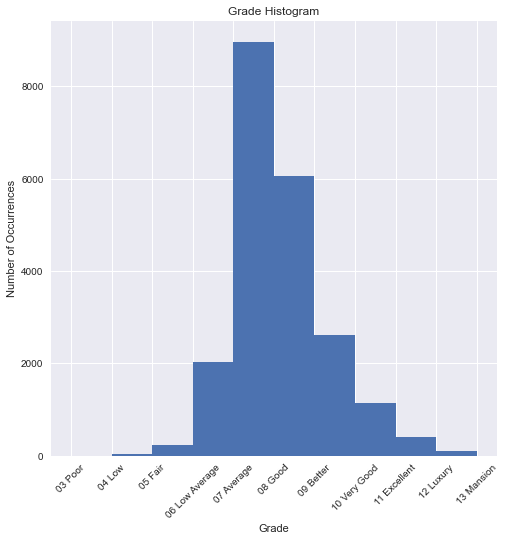

In [27]:
#Value counts
print(data['grade'].value_counts())

#The histogram doesn't plot the data in the correct order unless I
#change the names to include zeros before the single digits.
change_numerical_grade = {'3 Poor' : '03 Poor', '4 Low' : '04 Low', 
                          '5 Fair' : '05 Fair',
                          '6 Low Average' : '06 Low Average',
                          '7 Average' : '07 Average', '8 Good' : '08 Good',
                          '9 Better' : '09 Better'}

#Replacing the values temporarily
sorted_numerically = data['grade'].replace(change_numerical_grade).sort_values()

#Plotting the histogram.
plt.xticks(rotation = 45)
plt.title('Grade Histogram')
plt.ylabel('Number of Occurrences')
plt.xlabel('Grade')
sorted_numerically.hist(figsize = [8,8]);

Condition and grade are, and are not, conditionals. They are conditionals in the sense that they are currently strings, not numbers, but they are not conditionals because they represent a numerical scale. Therefore, they can be depicted numerically.

So, I'll convert both grade and condition to numerical values.

In [28]:
#Converting condition to numerical values
change_numerical_condition = {'1 Poor' : 1, '2 Fair' : 2, '3 Average' : 3,
                              '4 Good' : 4, '5 Very Good' : 5}  
data['condition'].replace(change_numerical_condition, inplace=True)
data['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [29]:
#Converting grade to numerical values
change_numerical_grade = {'3 Poor' : 3, '4 Low' : 4, '5 Fair' : 5,
                         '6 Low Average' : 6, '7 Average' : 7, '8 Good' : 8,
                         '9 Better' : 9, '10 Very Good' : 10, 
                         '11 Excellent' : 11, '12 Luxury' : 12,
                         '13 Mansion' : 13}
data['grade'].replace(change_numerical_grade, inplace=True)
data['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

# Histograms and Scatterplots
Now I'll plot histograms and scatterplots for the remaining numerical variables. To get started on deciding which variables to include in a model, I'll also build a model of each individual variable and calculate each models' R² value.

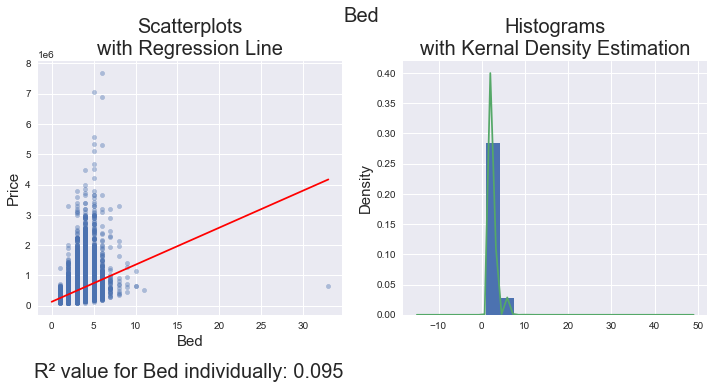

In [30]:
#Plotting the scatterplot and histogram for just bedrooms
scatter_hist(data, 'bedrooms')

Wow, That's an obvious outlier visible on the bedrooms scatterplot. There are no homes that include between 11 and 33 bedrooms, but one with 33 bedrooms. This ruins the scatterplot, and I'm sure skews the regression at least for a model that includes bedrooms. Before I continue, I'll look at the data on that one. 

In [31]:
#printing the data for all outliers in bedrooms
bedrooms_max = 12
bed_outlier = data[data['bedrooms']>=bedrooms_max]
bed_outlier

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0,5,7,1947


Thirty-three bedrooms in a 1620 SF home means that, assuming no other rooms exist in the house, each bedroom is 49 SF, or about 7'x7'. A little unlikely. I could assume the number 33 is a typo and modify it to be 3, but with such an egregious typo, I don't know what else is wrong about this data point, so I'll delete it. I'll also create a new DataFrame called model_data where I'll edit the data when needed.

In [32]:
#drop the outlier
model_data = data.drop(bed_outlier.index)

Now, to continue my plan to plot histograms and scatterplots of all the data.

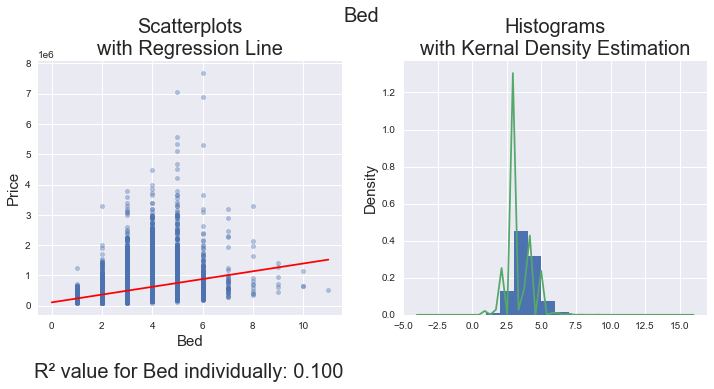

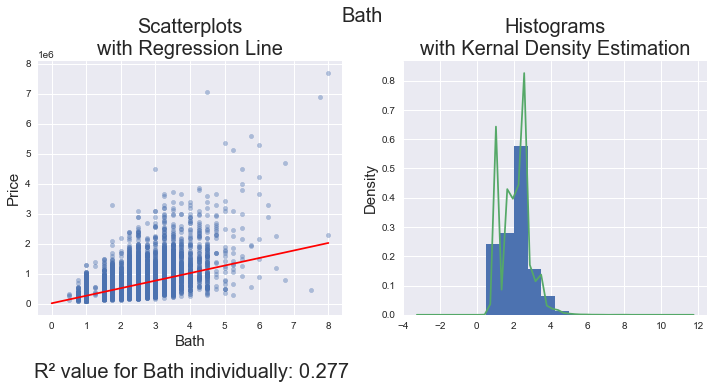

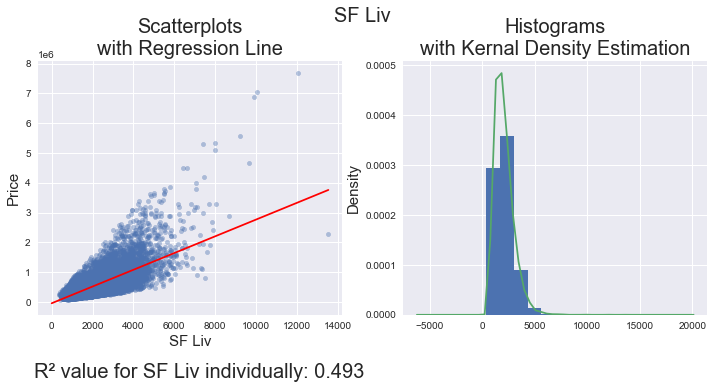

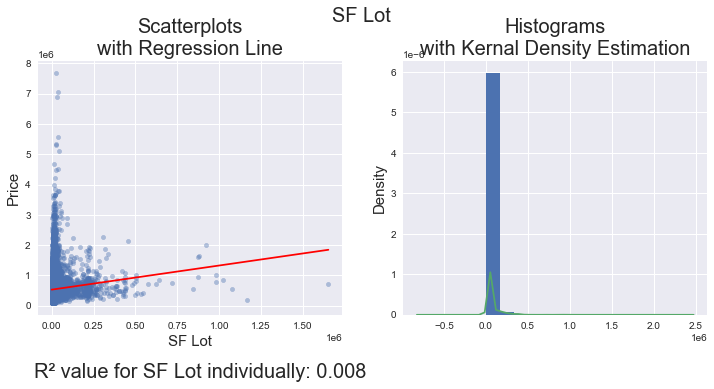

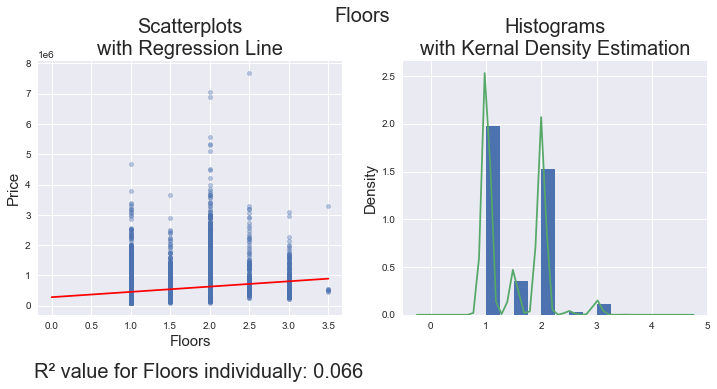

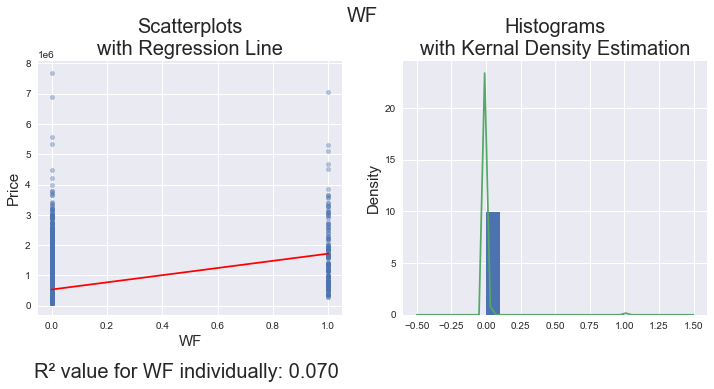

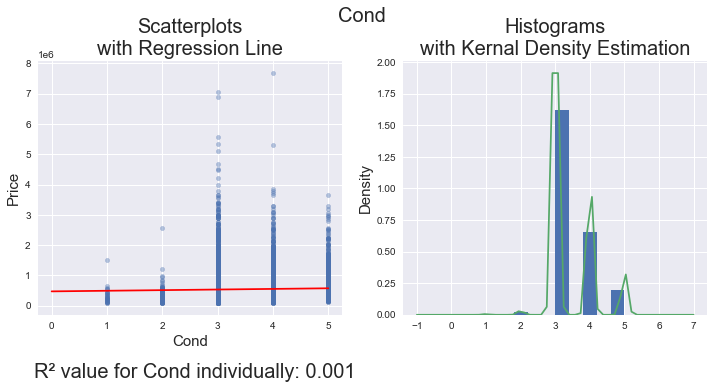

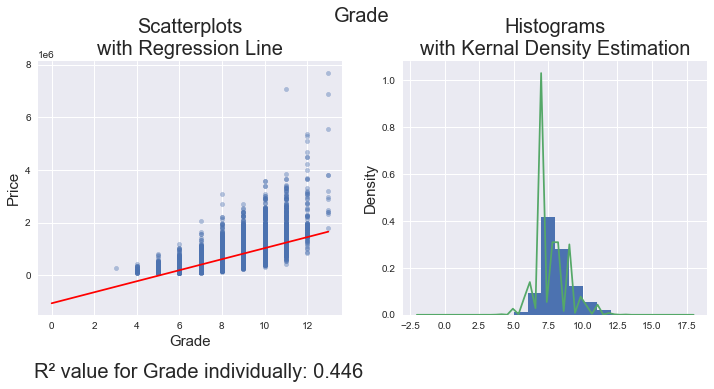

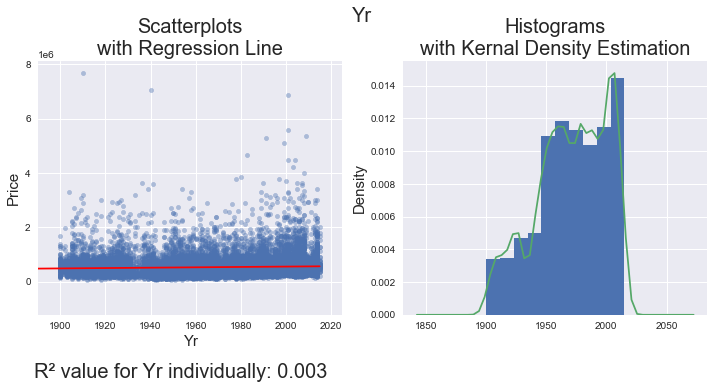

In [33]:
#Plotting scatterplots and histograms for all the variables
scatter_hist(model_data, 'bedrooms')
scatter_hist(model_data, 'bathrooms')
scatter_hist(model_data, 'sqft_living')
scatter_hist(model_data, 'sqft_lot')
scatter_hist(model_data, 'floors')
scatter_hist(model_data, 'waterfront')
scatter_hist(model_data, 'condition')
scatter_hist(model_data, 'grade')
scatter_hist(model_data, 'yr_built')

Now, I'll look at a matrix of scatter plots to see all the data at once and select which data should go into the model. I'll also drop the 'id' column, which doesn't tell me anything useful about the data.

In [34]:
#Dropping ID
model_data = model_data.drop(columns=['id'],axis=1)

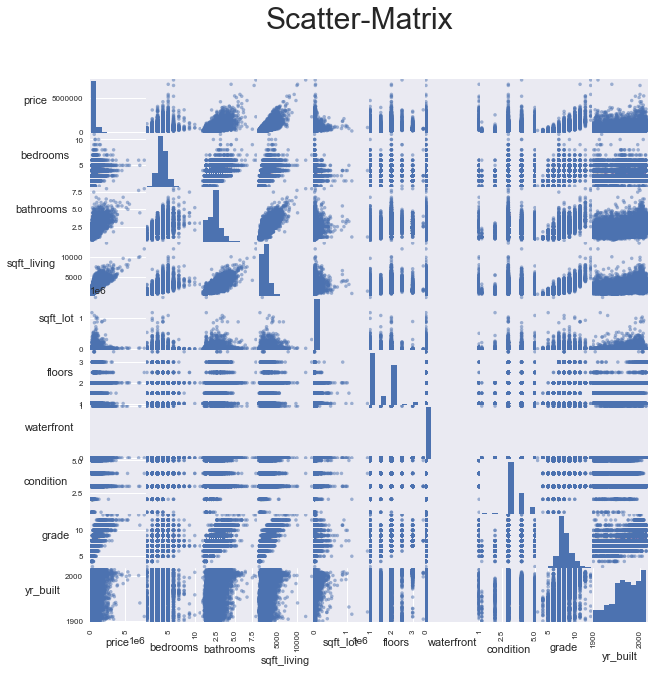

In [35]:
#Plotting the scattermatrix
axes = pd.plotting.scatter_matrix(model_data,figsize = [10, 10]);
plt.suptitle('Scatter-Matrix',size=30)
[plt.setp(item.yaxis.get_label(), 'rotation', 0) for item in axes.ravel()]
[plt.setp(item.yaxis.get_label(), 'ha', 'right') for item in axes.ravel()]

plt.show()

# Observations from the scatterplots and histograms & choosing variables to use in the first multivariable model.

I need to pick which variables I'll use for the first multivariable ordinary least squares model. I'll do this based on my observations of the scatter plots. There seems to be a correlation between price and the following variables: sqft_living, bathrooms, bedrooms and grade. Before I put those four variables in a model, I'll test them for multicollinearity. 

# Checking for Independence / Multicollinearity
The table below shows the Pearson Correlation Coefficient for each pair of variables available in the dataset.

In [36]:
#This creates the initial DataFrame to be added to later.
multicollinearity_test_data = model_data.copy()

#Running the multicollinearity test and displaying the results.
multicollinearity_test = multicollinearity_test_data.corr()
for c in multicollinearity_test.columns:
    multicollinearity_test[c] = multicollinearity_test[c].map('{:.3f}'.format)
multicollinearity_test

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
price,1.000,0.316,0.526,0.702,0.090,0.257,0.264,0.036,0.668,0.054
bedrooms,0.316,1.000,0.528,0.593,0.034,0.184,-0.002,0.023,0.366,0.161
bathrooms,0.526,0.528,1.000,0.756,0.088,0.503,0.064,-0.126,0.666,0.507
sqft_living,0.702,0.593,0.756,1.000,0.173,0.354,0.105,-0.059,0.763,0.318
sqft_lot,0.090,0.034,0.088,0.173,1.000,-0.005,0.021,-0.009,0.115,0.053
floors,0.257,0.184,0.503,0.354,-0.005,1.000,0.021,-0.264,0.459,0.489
waterfront,0.264,-0.002,0.064,0.105,0.021,0.021,1.000,0.017,0.083,-0.024
condition,0.036,0.023,-0.126,-0.059,-0.009,-0.264,0.017,1.000,-0.147,-0.362
grade,0.668,0.366,0.666,0.763,0.115,0.459,0.083,-0.147,1.000,0.448
yr_built,0.054,0.161,0.507,0.318,0.053,0.489,-0.024,-0.362,0.448,1.000


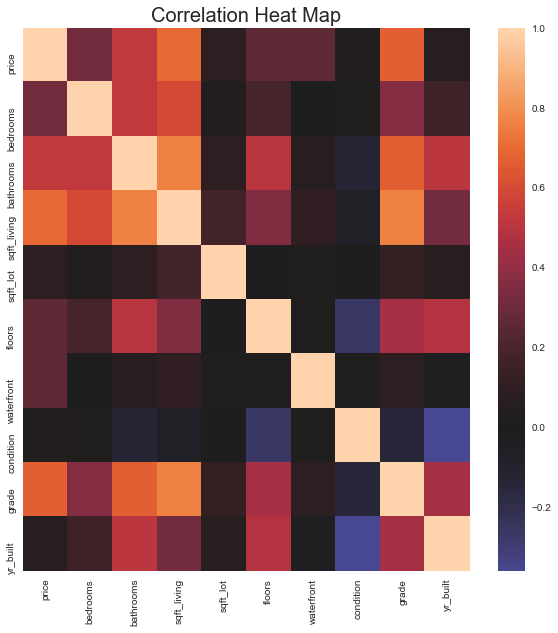

In [37]:
#Plotting the correlation heat map
plt.figure(figsize = (10,10))
heat = sns.heatmap(multicollinearity_test_data.corr(), center=0)
heat.set_title('Correlation Heat Map',size=20);

To filter out multicollinear pairs, I'll use a simple threshold test. I'll consider two variables collinear—and unfit to model together—if their Pearson Correlation Coefficient is higher than 0.75. From the data above, sqft_living is collinear with both grade and bathrooms.  

Most of the variables passed the multicollinearity test. From here forward, I will avoid using these multicollinear pairs in the same model. 

# First Multivariable Model
The first multivariable model will include bathrooms and grade.

In [38]:
#Setting the variables to be used
predictors = ['bathrooms', 'grade']

#Getting the model and the stats block
model_multi_1, model_multi_1_stats = model_stats(model_data,predictors,True)

#Adding a name to the stats block for easy identification 
model_multi_1_stats.insert(0,'Model Name','Model 1: First Attempt')

#Printing the summary
model_multi_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     9124.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:42:59   Log-Likelihood:            -3.0076e+05
No. Observations:               21596   AIC:                         6.015e+05
Df Residuals:                   21593   BIC:                         6.016e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.761e+05   1.28e+04    -76.404      0.000      -1e+06   -9.51e+05
bathrooms   6.965e+04   3207.953     21.713      0.000    6.34e+04    7.59e+04
grade       1.788e+05   2102.686     85.017      0.000    1.75e+05    1.83e+05
==============================================================================
Omnibus:                    19382.360   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1800058.400
Skew:                           3.944   Prob(JB):                         0.00
Kurtosis:                      47.025   Cond. No.                         57.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This next cell shows a DataFrame of my creation that gives easily comparable stats to other DataFrames. I call it the stats block. 

In [39]:
#Print the stats block
model_multi_1_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef
0,Model 1: First Attempt,Bath & Grade,2,0.458,0.0,False,-976050.8,3.9,47.0,1800058.4,548.1,57.0,69654.0,178764.1


# Testing the four assumptions of Linear Regression
I'll need to test these four assumptions multiple times through the process, but this first time I'll explain them as I go. The four assumptions of linear regression are:
1) Linearity
2) Normality
3) Homoscedasticity
4) Independence / Multicollinearity

# Linearity Assumption
The linearity assumption shows that as the X value increases, the Y value increases and follows the pattern of a straight line, with minimal deviations. To check for the linearity assumption. I need to draw regression lines across the scatterplots for each independent variable. 

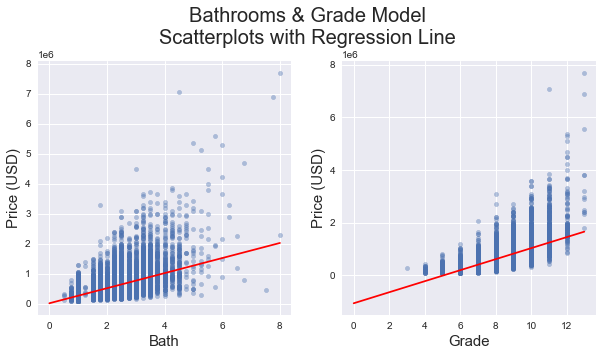

In [40]:
#Plotting assumption 1
assumption(1, model_data, model_multi_1, model_multi_1_stats,
    title = 'Bathrooms & Grade Model\nScatterplots with Regression Line')

Neither of these particularly pass the linearity assumption well. Both variable's price rises as the X-value rises, but they don't particularly follow a line.


# Normality Assumption
The normality assumption states that the residuals are normally distributed. To check this, I'll use a histogram and a Q-Q plot. Also, I'll use the Jarque-Bera test. If this was normally distributed, the Jaraque-Bera test statistic would be close to zero. If it's much higher than zero, it means the distribution is not normally distributed.

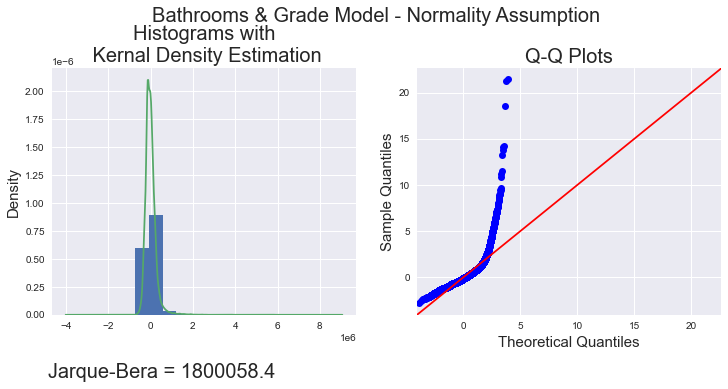

In [41]:
#Plotting assumption 2
assumption(2, model_data, model_multi_1, model_multi_1_stats,
    title = 'Bathrooms & Grade Model - Normality Assumption')

The graphs and Jarque-Bera test show that the residuals are not normally distributed.

# Homoscedasticity Assumption
The homoscedasticity assumption states that the residuals (y-values) plotted on a graph of the fitted values (x-values) will all fall between two parallel lines.  If the plot makes a cone-like shape, then it is not homoscedastic at all, but heteroscedastic, and thus fails the assumption. I'll also use the Breush-Pagan F-value test to verify what the graph tells me. Again, the closer the Breush-Pagan F-value is to zero, the more homoscedastic it is.

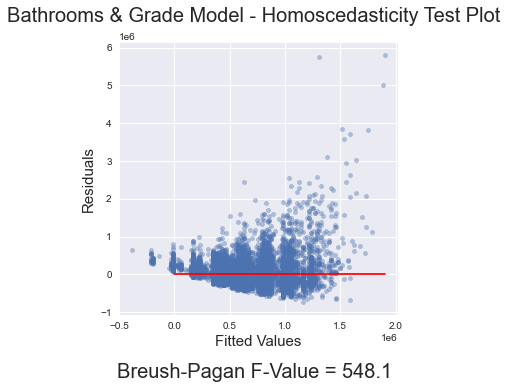

In [42]:
#Plotting assumption 3
assumption(3, model_data, model_multi_1, model_multi_1_stats,
    title = 'Bathrooms & Grade Model - Homoscedasticity Test Plot')

The data visibly makes a cone, and the Breush-Pagan F-Value is much too high to pass the homoscedasticity assumption. This data is certainly heteroscedastic.

# Independence / Multicollinearity Assumption
As I showed earlier, the variables selected are not multicollinear, but I'll print the heatmap again with just the variables in the model to prove it.

,Price,Bath,Grade
Price,1.000,0.526,0.668
Bath,0.526,1.000,0.666
Grade,0.668,0.666,1.000


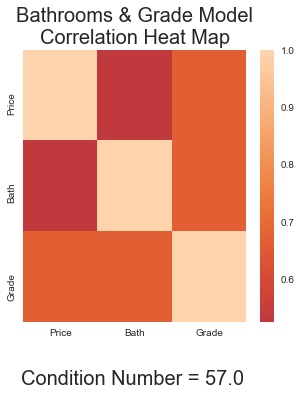

In [43]:
#Plotting assumption 4
assumption(4, model_data, model_multi_1, model_multi_1_stats,
    title='Bathrooms & Grade Model\nCorrelation Heat Map')

With the condition number above 30, multicollinearity exists within the model. However, since the Pearson Correlation Coefficients are all lower than .75, multicollinearity does not exist between individual variables in this model. For future iterations, I hope I can get the condition number to be lower.

# Observations on the Linear Regression Assumptions

The model doesn't pass any of the linearity assumptions, except for the fact that Pearson Correlation Coefficients are below 0.75 among the individual variables. However, considering this is real world data, that isn't surprising. The best I can do is improve some of the assumptions. For that, I'll make my second multivariable model.

# Adding more Variables to the model
In the first model, the R² value is not as high as I'd like it to be. To address this, I'm going to add more variables to see if I can raise R².

In [44]:
#Adding two new variables to the model
predictors = ['bathrooms', 'grade', 'waterfront', 'yr_built']

model_multi_2, model_multi_2_stats = model_stats(model_data,predictors,True)
model_multi_2_stats.insert(0,'Model Name','Model 2: Additional Variables')

model_multi_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     8007.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:43:00   Log-Likelihood:            -2.9756e+05
No. Observations:               21596   AIC:                         5.951e+05
Df Residuals:                   21591   BIC:                         5.952e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.755e+06   1.22e+05     63.655      0.000    7.52e+06    7.99e+06
bathrooms   1.339e+05   2913.561     45.952      0.000    1.28e+05     1.4e+05
grade       1.972e+05   1843.817    106.956      0.000    1.94e+05    2.01e+05
waterfront   8.31e+05   1.95e+04     42.646      0.000    7.93e+05    8.69e+05
yr_built   -4573.2790     63.795    -71.688      0.000   -4698.321   -4448.237
==============================================================================
Omnibus:                    18102.952   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1716672.449
Skew:                           3.503   Prob(JB):                         0.00
Kurtosis:                      46.112   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The stats block I created allows me to easily compare values from the two models.

In [45]:
#Creating a stats block to collect each iteration of the model
all_models_stats = model_multi_1_stats.append(model_multi_2_stats).reset_index(
    drop=True)

#Printing the new stats block
all_models_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef
0,Model 1: First Attempt,Bath & Grade,2,0.458,0.0,False,-976050.8,3.9,47.0,1800058.4,548.1,57.0,69654.0,178764.1,NaN,NaN
1,Model 2: Additional Variables,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7755125.8,3.5,46.1,1716672.4,454.1,151389.0,133884.6,197207.7,831014.6,-4573.3


And now to check the regression assumptions.

,Price,Bath,Grade,WF,Yr
Price,1.000,0.526,0.668,0.264,0.054
Bath,0.526,1.000,0.666,0.064,0.507
Grade,0.668,0.666,1.000,0.083,0.448
WF,0.264,0.064,0.083,1.000,-0.024
Yr,0.054,0.507,0.448,-0.024,1.000


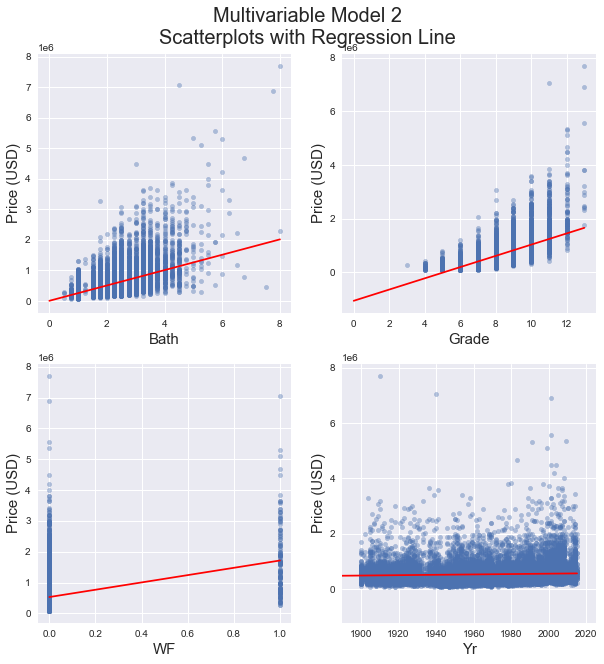

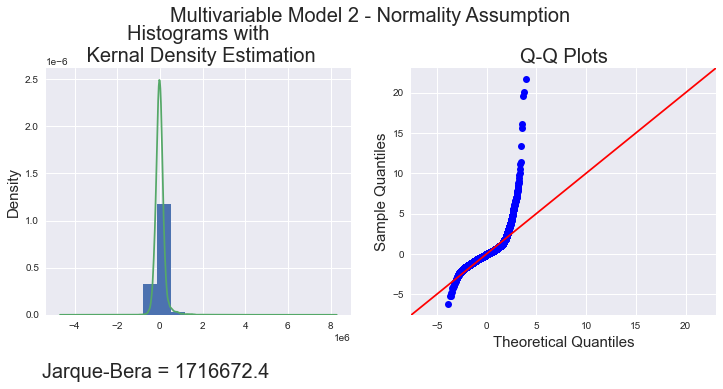

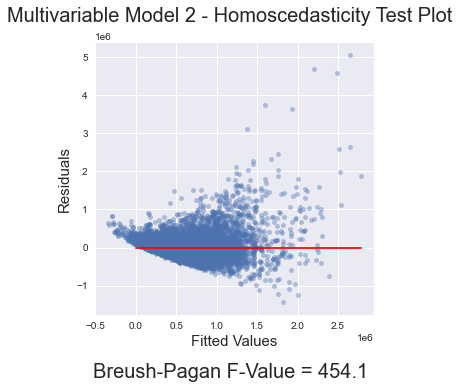

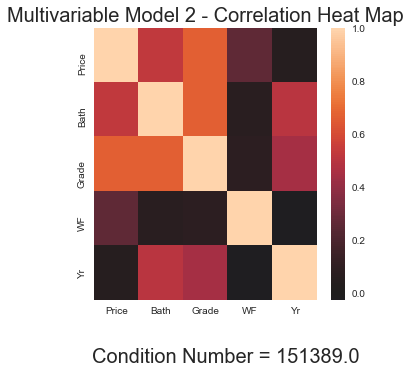

In [46]:
#Plotting all the regression assumptions at once
assumption(1, model_data, model_multi_2, model_multi_2_stats,
    title = 'Multivariable Model 2' +
           '\nScatterplots with Regression Line')
assumption(2, model_data, model_multi_2, model_multi_2_stats,
    title = 'Multivariable Model 2 ' +
           '- Normality Assumption')
assumption(3, model_data, model_multi_2, model_multi_2_stats,
    title = 'Multivariable Model 2 - Homoscedasticity Test Plot')
assumption(4, model_data, model_multi_2, model_multi_2_stats,
    title='Multivariable Model 2 - Correlation Heat Map')

The R² value went up much closer to where I'd like to see it, and the normality and homoscedasticity assumptions both improved, but this is at the cost of the condition number for multicollinearity, which shot way up. However, the improvements to R² make up for the degraded multicollinearity assumption, especially since the Pearson Correlation Coefficients are still all below 0.75.

This model is an improvement. Now I will try to make it better by removing some outliers.

# Removing outliers
I'll remove the largest and smallest values in each of the variables I used for Multivariable Model 2, including price. Removing outliers can quickly lead to diminishing returns, so I'll begin by iterating through an outlier removal function I wrote to see what the optimal number of outliers removed is.

In [47]:
#List of variables to drop
drop_outlier_variables = list(model_multi_2.params.index[1:])
drop_outlier_variables.append('price')

outlier_comparison = pd.DataFrame()

#Creating a dataframe that compares different numbers of dropped outliers
for i in range(1,11):
    iter_df, iter_mod, iter_stats = remove_outliers(
        model_data, drop_outlier_variables, i, True)
    outlier_comparison = outlier_comparison.append(iter_stats, ignore_index=True)
outlier_comparison

,Peak Values Dropped Per Variable,Dropped Rows,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef
0,1,4,"Bath, Grade, WF, Yr",4,0.599,0.0,True,7620374.2,3.2,38.2,1150140.4,492.9,151558.0,129915.6,196814.0,836361.6,-4499.3
1,2,8,"Bath, Grade, WF, Yr",4,0.598,0.0,True,7611303.2,3.2,38.3,1154206.5,492.1,151596.0,129717.8,196424.1,838555.1,-4493.1
2,3,12,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7544592.1,2.9,31.6,764908.4,565.8,151683.0,126869.1,196161.7,844110.8,-4455.3
3,4,16,"Bath, Grade, WF, Yr",4,0.599,0.0,True,7538529.0,2.9,31.7,768324.1,565.5,151744.0,126973.3,195887.3,848492.3,-4451.3
4,5,20,"Bath, Grade, WF, Yr",4,0.599,0.0,True,7547717.9,2.9,31.5,761023.8,534.4,151810.0,127056.7,195615.6,830239.4,-4455.0
5,6,24,"Bath, Grade, WF, Yr",4,0.598,0.0,True,7531955.4,2.9,31.7,771505.8,515.2,151817.0,126382.1,195416.6,820345.3,-4445.5
6,7,28,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7527941.7,2.9,31.8,775896.8,516.7,151817.0,126188.9,195216.8,821957.9,-4442.5
7,8,32,"Bath, Grade, WF, Yr",4,0.596,0.0,True,7524397.5,2.9,32.0,787112.1,510.6,151824.0,125875.2,195120.5,814698.4,-4440.0
8,9,35,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7502573.4,2.8,29.7,666855.1,539.1,151830.0,124939.6,194703.2,812837.0,-4426.4
9,10,38,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7492668.3,2.8,29.7,667957.2,536.6,151836.0,124157.8,194723.6,817868.7,-4420.7


It looks like the maximum effectiveness for removing high value outliers is getting rid of the top three outliers in each variable. Now, I'll take the dataset that remains and experiment with removing low outliers.

In [48]:
#Creating the new culled DataFrame, Model and Stats Block
model_data_trim, model_trim, model_trim_stats = remove_outliers(
        model_data, drop_outlier_variables, 3, True)
model_trim_stats = model_trim_stats.iloc[:,2:]
model_trim_stats.insert(0,'Model Name','Model 3: Removed Outliers')

#List of variables to drop
drop_outlier_variables = list(model_trim.params.index[1:])
drop_outlier_variables.append('price')

outlier_comparison = pd.DataFrame()

#Creating a DataFrame that shows results for different numbers
#of low outliers removed.
for i in range(1,11):
    iter_df, iter_mod, iter_stats = remove_outliers(
        model_data_trim, drop_outlier_variables, i, True, False)
    outlier_comparison = outlier_comparison.append(iter_stats, 
                                                   ignore_index=True)
outlier_comparison

,Peak Values Dropped Per Variable,Dropped Rows,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef
0,1,5,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7542616.7,2.9,31.6,764660.1,566.3,151681.0,126808.1,196299.1,844027.2,-4454.8
1,2,8,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7542635.5,2.9,31.6,764349.4,566.3,151705.0,126814.0,196328.7,844000.1,-4454.9
2,3,12,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7540598.9,2.9,31.6,766479.4,567.6,151741.0,126875.1,196321.0,844060.9,-4453.9
3,4,16,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7544479.8,2.9,31.6,766798.8,567.8,151760.0,126900.8,196391.7,843945.6,-4456.2
4,5,20,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7543723.7,2.9,31.6,766655.0,567.9,151761.0,126821.8,196489.1,843904.9,-4456.1
5,6,24,"Bath, Grade, WF, Yr",4,0.601,0.0,True,7545205.6,2.9,31.6,766599.2,568.0,151791.0,126896.8,196500.2,843872.2,-4457.0
6,7,28,"Bath, Grade, WF, Yr",4,0.601,0.0,True,7546584.5,2.9,31.6,766420.4,568.8,151833.0,126903.0,196614.0,843763.2,-4458.2
7,8,32,"Bath, Grade, WF, Yr",4,0.601,0.0,True,7545292.6,2.9,31.6,766109.1,568.8,151840.0,126854.6,196667.1,843742.4,-4457.7
8,9,36,"Bath, Grade, WF, Yr",4,0.601,0.0,True,7546837.0,2.9,31.6,766232.1,569.5,151846.0,126854.0,196805.2,843627.8,-4459.1
9,10,40,"Bath, Grade, WF, Yr",4,0.601,0.0,True,7549152.6,2.9,31.6,765871.2,569.7,151866.0,126889.5,196863.6,843557.7,-4460.5


This does nothing useful. I'll stick with just removing the top three outliers per variable, which removes a total of 12 outliers.

In [49]:
all_models_stats = all_models_stats.append(model_trim_stats)
all_models_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef
0,Model 1: First Attempt,Bath & Grade,2,0.458,0.0,False,-976050.8,3.9,47.0,1800058.4,548.1,57.0,69654.0,178764.1,NaN,NaN
1,Model 2: Additional Variables,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7755125.8,3.5,46.1,1716672.4,454.1,151389.0,133884.6,197207.7,831014.6,-4573.3
0,Model 3: Removed Outliers,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7544592.1,2.9,31.6,764908.4,565.8,151683.0,126869.1,196161.7,844110.8,-4455.3


# Model Transformations
I am mostly happy with Model 3, but I'll see if I can improve it with a log transformation. The code below creates one model per variable, logging all the values of one variable, and then prints the stats block to compare the differences. However, waterfront is omitted since logging a binary variable is useless.

In [50]:
#This sets up the variables used in the code below
variables = drop_outlier_variables
logged_variables = variables.copy()
logged_variables.append('price')
logs = log_data(model_data_trim, logged_variables, keep=True)
logs = logs.drop(columns='waterfront_log')
log_variables = list(logs.iloc[:,-3:].columns)
log_variables.append('price_log')
log_var_original = variables.copy()
log_var_original.remove('waterfront')
log_var_original.append('price')
log_model_stats = pd.DataFrame()
i=0

#This for loop performs the transformation and creates the
#four models and stats block for quick comparison.
for replace, log in zip(log_var_original, log_variables):
    var = variables.copy()
    i+=1
    if replace == 'price':
        logs_price_logged = logs.copy()
        logs_price_logged['price'] = logs_price_logged['price_log']
        log_iter = model_stats(logs_price_logged, var, model_return=False)
        log_iter.iloc[0,0] = 'Bath, Grade, WF, Yr (Price Logged)'
        log_iter.insert(0,'Model Name',f'Log Test {i}')
        log_model_stats = log_model_stats.append(log_iter)
    else:
        var.remove(replace)
        var.append(log)
        log_iter = model_stats(logs, var, model_return=False)
        log_iter.insert(0,'Model Name',f'Log Test {i}')
        log_model_stats = log_model_stats.append(log_iter)

log_model_stats

<ipython-input-3-96f531ddf114>:17: RuntimeWarning: divide by zero encountered in log
  df_log[order[i] + '_log'] = df[order[i]].map(lambda x : np.log(x))


,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Log(Bath) Coef,Grade Coef,WF Coef,Yr Coef,Bath Coef,Log(Grade) Coef,Log(Yr) Coef
0,Log Test 1,"Grade, WF, Yr, Log(Bath)",4,0.582,0.0,True,7284400.0,3.0,33.1,847999.1,519.4,155255.0,177706.2,211183.9,863631.8,-4306.6,NaN,NaN,NaN
0,Log Test 2,"Bath, WF, Yr, Log(Grade)",4,0.570,0.0,True,6226866.7,3.0,32.1,793986.9,501.4,151003.0,NaN,NaN,875481.1,-4515.9,141049.7,1437027.3,NaN
0,Log Test 3,"Bath, Grade, WF, Log(Yr)",4,0.600,0.0,True,65085413.1,2.9,31.6,766094.7,565.7,6664.0,NaN,196119.1,844574.8,NaN,126575.2,NaN,-8742369.3
0,Log Test 4,"Bath, Grade, WF, Yr (Price Logged)",4,0.611,0.0,True,23.1,-0.1,3.3,101.3,26.5,151683.0,NaN,0.3,0.6,-0.0,0.2,NaN,NaN


Logging the price made a dramatic difference in all critical stats except for condition number. However, I don't want to explain to my client what the log of a price means, so I'm going to pass on using that in this project. It is intriguing though.

Otherwise, there were no discernable improvements for R², but Log Test 3 shows a lower condition number. I'll add that to my stats block that lists each version of the model I've created.

In [51]:
#Adds the best model from above to the stats block collection
log_model_stats.iloc[2,0] = 'Model 4: Logged Year'
all_models_stats = all_models_stats.append(log_model_stats.iloc[2,:])
all_models_stats.dropna(axis=1,how = 'all', inplace=True)
all_models_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef,Log(Yr) Coef
0,Model 1: First Attempt,Bath & Grade,2,0.458,0.0,False,-976050.8,3.9,47.0,1800058.4,548.1,57.0,69654.0,178764.1,NaN,NaN,NaN
1,Model 2: Additional Variables,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7755125.8,3.5,46.1,1716672.4,454.1,151389.0,133884.6,197207.7,831014.6,-4573.3,NaN
0,Model 3: Removed Outliers,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7544592.1,2.9,31.6,764908.4,565.8,151683.0,126869.1,196161.7,844110.8,-4455.3,NaN
0,Model 4: Logged Year,"Bath, Grade, WF, Log(Yr)",4,0.600,0.0,True,65085413.1,2.9,31.6,766094.7,565.7,6664.0,126575.2,196119.1,844574.8,NaN,-8742369.3


The improvement to the condition number encourages me to try normalization in the same way I tried logs. The code below performs min/max scaling on each variable and price and then puts it in the stats block to see what improvements are made. Again, it excludes waterfront.

In [52]:
#This sets up the variables used in the code below
normed_variables = variables.copy()
normed_variables.append('price')
norm = scale_data(model_data_trim, logged_variables, keep=True)
norm = norm.drop(columns='waterfront_scale')
norm_variables = list(norm.iloc[:,-3:].columns)
norm_variables.append('price_scale')
norm_var_original = variables.copy()
norm_var_original.remove('waterfront')
norm_var_original.append('price')
norm_model_stats = pd.DataFrame()
i=0

#This for loop performs the transformation and creates the
#four models and stats block for quick comparison.
for replace, norm_v in zip(log_var_original, norm_variables):
    var = variables.copy()
    i+=1
    if replace == 'price':
        norm_price_norm = norm.copy()
        norm_price_norm['price'] = norm_price_norm['price_scale']
        norm_iter = model_stats(norm_price_norm, var, model_return=False)
        norm_iter.iloc[0,0] = 'Bath, Grade, WF, Yr (Price Scaled)'
        norm_iter.insert(0,'Model Name',f'Norm Test {i}')
        norm_model_stats = norm_model_stats.append(norm_iter)
    else:
        var.remove(replace)
        var.append(norm_v)
        norm_iter = model_stats(norm, var, model_return=False)
        norm_iter.insert(0,'Model Name',f'Norm Test {i}')
        norm_model_stats = norm_model_stats.append(norm_iter)

norm_model_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Norm Bath Coef,Grade Coef,WF Coef,Yr Coef,Bath Coef,Norm Grade Coef,Norm Yr Coef
0,Norm Test 1,"Grade, WF, Yr, Norm Bath",4,0.6,0.0,True,7608026.6,2.9,31.6,764908.4,565.8,152582.0,888083.6,196161.7,844110.8,-4455.3,NaN,NaN,NaN
0,Norm Test 2,"Bath, WF, Yr, Norm Grade",4,0.6,0.0,True,8133077.2,2.9,31.6,764908.4,565.8,152521.0,NaN,NaN,844110.8,-4455.3,126869.1,1961616.9,NaN
0,Norm Test 3,"Bath, Grade, WF, Norm Yr",4,0.6,0.0,True,-920435.3,2.9,31.6,764908.4,565.8,101.0,NaN,196161.7,844110.8,NaN,126869.1,NaN,-512356.9
0,Norm Test 4,"Bath, Grade, WF, Yr (Price Scaled)",4,0.6,0.0,True,1.1,2.9,31.6,764908.4,565.8,151683.0,NaN,0.0,0.1,-0.0,0.0,NaN,NaN


When I normalized year, the condition number dropped to its lowest value for a four-variable model, with no change to the other values. I'll add this to my stats block.

In [53]:
#Adds normalized year to the stats block collection
norm_model_stats.iloc[2,0] = 'Model 5: Normalized Year'
all_models_stats = all_models_stats.append(norm_model_stats.iloc[2,:])
all_models_stats.dropna(axis=1,how = 'all', inplace=True)
all_models_stats

,Model Name,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bath Coef,Grade Coef,WF Coef,Yr Coef,Log(Yr) Coef,Norm Yr Coef
0,Model 1: First Attempt,Bath & Grade,2,0.458,0.0,False,-976050.8,3.9,47.0,1800058.4,548.1,57.0,69654.0,178764.1,NaN,NaN,NaN,NaN
1,Model 2: Additional Variables,"Bath, Grade, WF, Yr",4,0.597,0.0,True,7755125.8,3.5,46.1,1716672.4,454.1,151389.0,133884.6,197207.7,831014.6,-4573.3,NaN,NaN
0,Model 3: Removed Outliers,"Bath, Grade, WF, Yr",4,0.600,0.0,True,7544592.1,2.9,31.6,764908.4,565.8,151683.0,126869.1,196161.7,844110.8,-4455.3,NaN,NaN
0,Model 4: Logged Year,"Bath, Grade, WF, Log(Yr)",4,0.600,0.0,True,65085413.1,2.9,31.6,766094.7,565.7,6664.0,126575.2,196119.1,844574.8,NaN,-8742369.3,NaN
0,Model 5: Normalized Year,"Bath, Grade, WF, Norm Yr",4,0.600,0.0,True,-920435.3,2.9,31.6,764908.4,565.8,101.0,126869.1,196161.7,844110.8,NaN,NaN,-512356.9


I'm going to stop now. Iterations could go on forever. I like model 5 because it gives a good R² value, it has both the lowest Jarque-Bera and condition number in a 4-variable model, and its Breush-Pagan F-value is acceptable.

# Final Model
Here is the summary of the Final Model.

In [54]:
#This formally creates the best model available in the stats block
#collection
model5_data = norm.copy()
variables = ['bathrooms', 'grade', 'waterfront', 'yr_built_scale']
model5, model5_stats = model_stats(model5_data, variables, model_return=True)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     8083.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:43:04   Log-Likelihood:            -2.9685e+05
No. Observations:               21584   AIC:                         5.937e+05
Df Residuals:                   21579   BIC:                         5.937e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -9.204e+05   1.08e+04    -85.409      0.000   -9.42e+05   -8.99e+05
bathrooms       1.269e+05   2853.821     44.456      0.000    1.21e+05    1.32e+05
grade           1.962e+05   1799.935    108.983      0.000    1.93e+05       2e+05
waterfront      8.441e+05   1.92e+04     43.959      0.000    8.06e+05    8.82e+05
yr_built_scale -5.124e+05   7172.811    -71.430      0.000   -5.26e+05   -4.98e+05
==============================================================================
Omnibus:                    15378.363   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           764908.385
Skew:                           2.884   Prob(JB):                         0.00
Kurtosis:                      31.588   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since this is the final model, I'll check the liner regression assumptions again.

,Price,Bath,Grade,WF,Norm Yr
Price,1.000,0.521,0.670,0.269,0.056
Bath,0.521,1.000,0.664,0.063,0.510
Grade,0.670,0.664,1.000,0.082,0.449
WF,0.269,0.063,0.082,1.000,-0.026
Norm Yr,0.056,0.510,0.449,-0.026,1.000


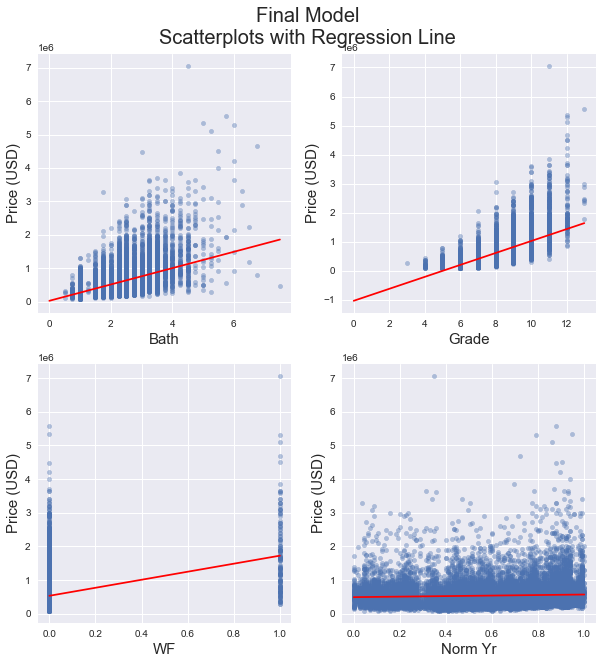

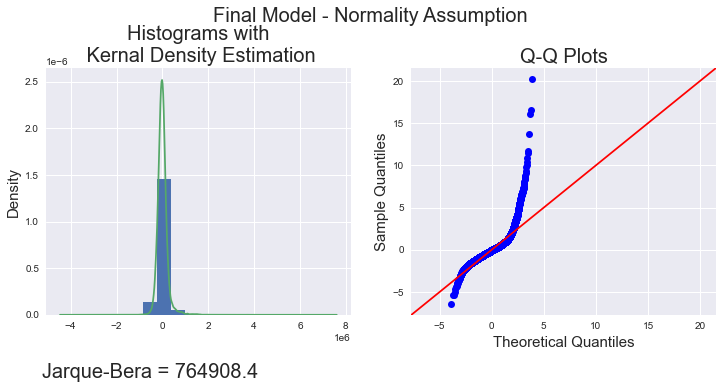

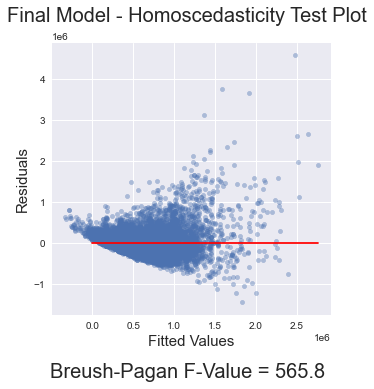

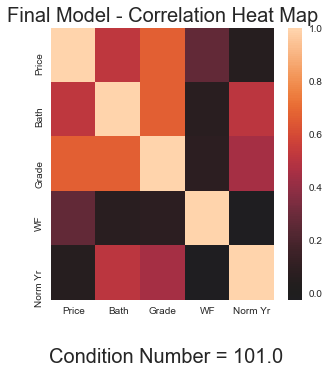

In [55]:
#This checks all the assumptions at once, again
assumption(1, model5_data, model5, model5_stats,
    title = 'Final Model' +
           '\nScatterplots with Regression Line')
assumption(2, model5_data, model5, model5_stats,
    title = 'Final Model ' +
           '- Normality Assumption')
assumption(3, model5_data, model5, model5_stats,
    title = 'Final Model - Homoscedasticity Test Plot')
assumption(4, model5_data, model5, model5_stats,
    title = 'Final Model - Correlation Heat Map')

Each of the four assumptions of linear regression have either improved or stayed relatively the same from previously tested models. It's time to draw conclusions from this model.

# Final Model Visualizations
Before I create visualizations, I'll need to write a quick function that allows me to enter values for the variables and return a predicted price. With four independent variables in the model, I'll see what the average value is for each and set those averages as the default parameter values for each variable. Then, I can change any one value to let me see how a single value will change the model. 

So first, I'll calculate the average of each.

In [56]:
#This calculates the averages for each variable
bath = round(model5_data['bathrooms'].mean()*4)/4 #Rounds to nearest 0.25
gr = int(round(model5_data['grade'].mean())) #Rounds to nearest int
wf = int(round(model5_data['waterfront'].mean())) #Rounds to nearest int
yr = int(round(model5_data['yr_built'].mean())) #Rounds to nearest int
yr_norm = model5_data['yr_built_scale'].mean() #No rounding for a float

#This prints them
print('             Bathroom Average:', bath)
print('                Grade Average:', gr)
print('           Waterfront Average:', wf)
print('           Year Built Average:', yr)
print('Normalized Year Built Average:', yr_norm)

             Bathroom Average: 2.0
                Grade Average: 8
           Waterfront Average: 0
           Year Built Average: 1971
Normalized Year Built Average: 0.6173232184871241


Now to create the prediction function.

In [57]:
#The parameters are set to their respective calculated averages found above
def final_model_predict(mod = model5, bath = 2, gr = 8, wf = 0,
                        yr = 0.6173232184871241):
    
    #This sets the coefficients for the final model
    intercept, bath_coef, grade_coef, wf_coef, yr_norm_coef = mod.params
    
    #This calculates the predicted y-value
    y = (bath*bath_coef +gr*grade_coef + wf*wf_coef + 
         yr*yr_norm_coef + intercept)
    return y

Now I'll see how entering the averages into the model compares to the average price in the model itself.

In [58]:
#Calculating the values printed below
average_data = model5_data['price'].mean()
average_model = final_model_predict()
average_residual_abs = model5.resid.map(lambda x : abs(x)).mean()
diff = average_model - average_data

#Printing the data
print('       The average price in the data used to create the model: ' + 
      '${:,.2f}'.format(model5_data['price'].mean()))
print("The calculated price with each variables' average in the model: " + 
      '${:,.2f}'.format(final_model_predict()))
print()
print('                 The difference between the above two numbers:  ' + 
      '${:,.2f}'.format(diff))
print('         The average absolute value of residuals in the model: ' + 
      '${:,.2f}'.format(average_residual_abs))

       The average price in the data used to create the model: $538,977.72
The calculated price with each variables' average in the model: $586,306.59

                 The difference between the above two numbers:  $47,328.87
         The average absolute value of residuals in the model: $148,193.72


The data above tells me that when I use the average of each variable in the model, the price the model yields is close to the average price of the data_set.

Now, the visualizations.

# Bathroom Visualization
The following visualizations all follow the same pattern. The first X-value is the lowest value of the chosen independent variable. The graph then shows the change in price while moving up the highest value of the independent variable. I will set all the other variables in the model to their average, with the exception of Waterfront. Waterfront is a binary value. Afterall, a house is, or is not, on a waterfront. In a linear model, that works out to a set amount added to the price, or not added. Each visualization will feature two lines of the same independent variable changing, one representing homes on a waterfront and the other homes not on a waterfront.

<ipython-input-11-0c9268346ede>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['${:,.0f}K'.format(x)


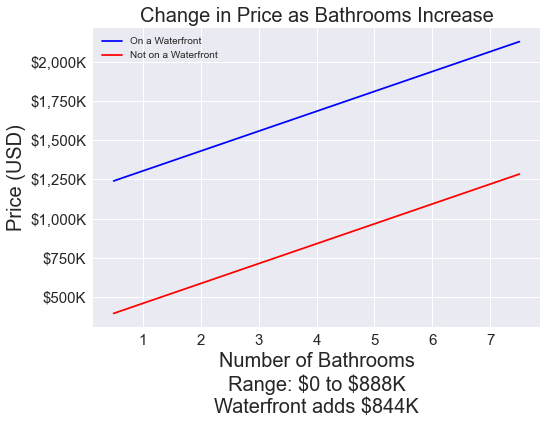

In [59]:
#Calculating the bounds of the graph
bath_min = model5_data['bathrooms'].min()
bath_max = model5_data['bathrooms'].max()
bath_x = []
bath_y = []

#Creating the points on the line
for bath in np.arange(bath_min,bath_max + .25, .25):
    bath_x.append(bath)
    bath_y.append(final_model_predict(bath=bath)/1000)

#Creating the graph
simple_line(bath_x, bath_y, xlabel = 'Number of Bathrooms',
            title = 'Change in Price as Bathrooms Increase', wf = 1)

Assuming the number of bathrooms is not going to be larger or smaller than the maximum or minimum of the dataset, then the number of bathrooms can add up to \\$888K to the price of a home. As always, the home being on a waterfront adds $844K to the price of the home.

# Grade Rating Visualization

<ipython-input-11-0c9268346ede>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['${:,.0f}K'.format(x)


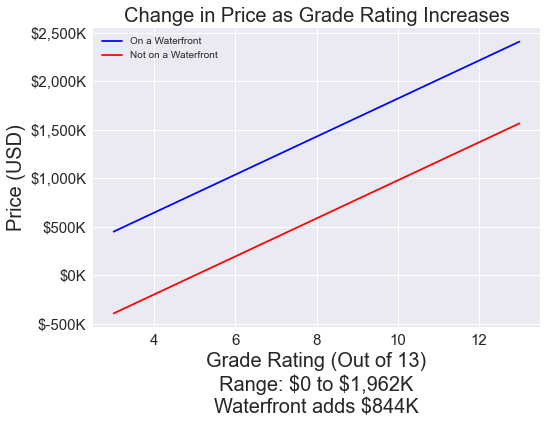

In [60]:
#Calculating the bounds of the graph
grade_min = model5_data['grade'].min()
grade_max = model5_data['grade'].max()
grade_x = []
grade_y = []

#Creating the points on the line
for gr in range(3, grade_max + 1):
    grade_x.append(gr)
    grade_y.append(final_model_predict(gr=gr)/1000)
    
#Creating the graph
simple_line(grade_x, grade_y, xlabel = 'Grade Rating (Out of 13)',
            title = 'Change in Price as Grade Rating Increases', wf = 1)

Assuming the grade rating is not going to be larger or smaller than the maximum or minimum of the dataset, then the grade rating can add up to \\$1,962K to the price of a home. As always, the home being on a waterfront adds $844K to the price of the home.

# Year Built Visualization

<ipython-input-11-0c9268346ede>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['${:,.0f}K'.format(x)


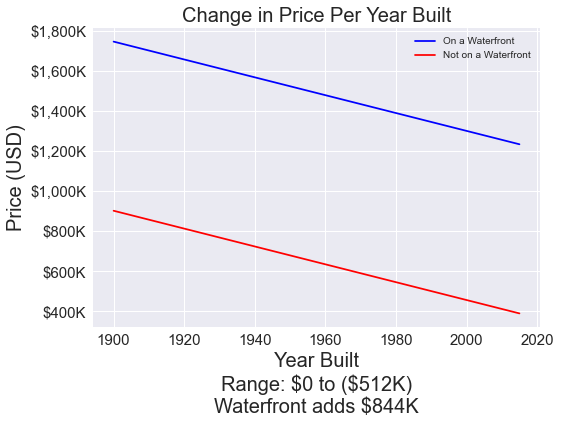

In [61]:
#Calculating the bounds of the graph
year_min = model5_data['yr_built'].min()
year_max = model5_data['yr_built'].max()
year_x = []
year_y = []

#Creating the points on the line
for yr in range(year_min,year_max + 1):
    year_x.append(yr)
    yr_scale = (yr-year_min)/(year_max-year_min)
    year_y.append(final_model_predict(yr = yr_scale)/1000)

#Creating the graph
simple_line(year_x, year_y, xlabel = 'Year Built',
           title = 'Change in Price Per Year Built', wf = 1)

#This centers all the plots in the notebook. Placed at the
#end for functional purposes
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

If we assume the year built is not going to be larger or smaller than the maximum or minimum of the dataset, then the build year can subtract up to \\$512K to the price of a home. As always, the home being on a waterfront adds $844K to the price of the home.

# Conclusions
As my contract specified, here are three conclusions from three variables I used in my model, and an observation on the fourth.

### 1) Each digit of a home's grade rating is worth nearly \$200,000.

Of the four independent variables I included in my model, Grade had a stronger effect on the price than any other. This is interesting because Grade is also a slightly subjective number based on King County criteria. It may be difficult for an individual to guess what King County would grade a home based on the criteria, but it is very easy to look up how King County graded a home.

For a salesman to optimize their efforts, they could look up homes at a specific grade and then target those homes.

### 2) A home's existence on a waterfront adds \$844K to a home's sale price.

Perhaps because there are so few waterfront properties in King County, those that have waterfront status are worth a $0.84 million more. That's quite a bump for a single additional feature to a home.

A salesman could target waterfront properties specifically, and offer their services as someone with waterfront sales experience to generate more business. This could have a profound snowball effect, leading to higher commissions again and again. However, as I mentioned, there are a limited number of homes in King County that are on the waterfront, so whenever they are available, salesmen should lobby their owners for the opportunity to represent them.

### 3) Homes with more bathrooms sell at higher prices, at about \$148K per full bathroom, or \$74K per half bath, or \$37K per quarter bath.

Salesmen can expect higher prices for homes with more bathrooms. Each bathroom can add \$148K to the expected sale price. 

Salesmen can easily search for homes with more bathrooms and target those.

### Bonus insight: Older homes have advantages that outshine their age.

The model shows that the newer the home is, the cheaper the price is. This is misleading. It's pointing to something that is desirable about older homes that newer homes cannot compete with. The likely cause of this phenomenon is that older homes were built in more desirable locations that are no longer accessible to new builds. Regardless, more research needs to be done on this topic.

# Appendix
### An arduous journey to the allusive perfect R²

This contract initially overwhelmed me. I was under the impression that the client wanted the highest R² value possible, and wouldn't accept any R² value below 0.6. I later learned this wasn't true, but while I thought it was reality, I embarked on a journey to make R² as high as possible. 

I started by creating a function that put every possible combination of variables into a model, and created the table that I later called the stats block to tell me which combinations yielded the highest R². Here are the results of that: 

In [62]:
#The mega function
models_trim = mega_models_no_trans(model_data,1,9)
models_trim

Combos of 1 variables (1/9).
Skipped 0 iterations due to multicollinearity.
0 models discarded due to low R².
9 Models met minimum requirements.

Combos of 2 variables (2/9).
Skipped 2 iterations due to multicollinearity.
0 models discarded due to low R².
34 Models met minimum requirements.

Combos of 3 variables (3/9).
Skipped 13 iterations due to multicollinearity.
0 models discarded due to low R².
71 Models met minimum requirements.

Combos of 4 variables (4/9).
Skipped 36 iterations due to multicollinearity.
0 models discarded due to low R².
90 Models met minimum requirements.

Combos of 5 variables (5/9).
Skipped 55 iterations due to multicollinearity.
0 models discarded due to low R².
71 Models met minimum requirements.

Combos of 6 variables (6/9).
Skipped 50 iterations due to multicollinearity.
0 models discarded due to low R².
34 Models met minimum requirements.

Combos of 7 variables (7/9).
Skipped 27 iterations due to multicollinearity.
0 models discarded due to low R².
9 Mo

,Model Variable(s),Num Variables,R²,P-value,Neg Coef?,Intercept,Skewness,Kurtosis,Jarque-Bera,Breush-Pagan F-Value,Cond. No,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef
0,"Bed, Bath, SF Lot, Floors, WF, Cond, Grade, Yr",8,0.598,0.0,True,7442803.0,3.5,46.7,1761415.5,233.7,3824447.0,-2611.1,132914.0,NaN,0.1,6014.3,828690.9,19483.4,196978.5,-4447.3
1,"Bed, Bath, Floors, WF, Cond, Grade, Yr",7,0.598,0.0,True,7438016.4,3.5,46.6,1755944.7,266.2,170982.0,-2707.0,133165.3,NaN,NaN,5463.1,829082.9,19477.8,197292.8,-4445.1
2,"Bath, SF Lot, WF, Cond, Grade, Yr",6,0.598,0.0,True,7370254.4,3.5,46.6,1755344.2,301.0,3704604.0,NaN,132268.8,NaN,0.1,NaN,830041.9,18683.6,197312.6,-4409.6
3,"Bath, WF, Cond, Grade, Yr",5,0.598,0.0,True,7368997.3,3.5,46.6,1751367.6,360.4,165648.0,NaN,132352.7,NaN,NaN,NaN,830464.5,18723.1,197567.5,-4409.5
4,"Bath, SF Lot, Floors, WF, Cond, Grade, Yr",7,0.598,0.0,True,7420633.4,3.5,46.8,1767747.3,264.0,3792024.0,NaN,131121.3,NaN,0.1,6341.3,830051.7,19311.4,196823.9,-4437.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,SF Lot & Cond,2,0.009,0.0,False,457292.5,4.0,37.9,1153126.3,10.8,245129.0,NaN,NaN,NaN,0.8,NaN,NaN,20798.2,NaN,NaN
315,SF Lot,1,0.008,0.0,False,528252.7,4.0,37.8,1147576.2,18.9,46918.0,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN
316,Cond & Yr,2,0.006,0.0,False,-1482407.7,4.0,37.9,1156537.8,3.4,146255.0,NaN,NaN,NaN,NaN,NaN,NaN,36086.5,NaN,963.8
317,Yr,1,0.003,0.0,False,-789921.4,4.0,37.7,1142385.5,1.4,132280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.9


The dataset used in this function only had one outlier removed, the erroneous 33 bed home found early in the project. With that dataset, none of the R² values were above the non-existent minimum R² my client had allegedly set, 0.6. Also, the model that got as close to R² as possible used every variable that didn't have too high a Pearson Correlation Coefficient with any of the other variables. Not exactly telling. 

At this point, I was frustrated with the idea of selecting different independent variables, picking a transformation and trying to mash them together to improve the R² value. Instead, I wrote a function that combined all variables and transformation combinations into a model. This function took an exceptionally long time to run, more than twenty-four hours. I had to use the print function to provide feedback during the calculation process to ensure that the function hadn't frozen. These feedback lines were also used in the function above.

This new function selects a set number of independent variables, iterates through the original values and the four different transformations for each variable (Log, normalization, normalization of the logged data, and squared) to create a model for each possible combination of variables and their respective transformations. Since the Waterfront category is binary, I did not perform any transformation on that particular column through my analysis. I wrote the function to omit waterfront from receiving any transformations, yet still included it in the data when called upon. Finally, the function also filters out multicollinear pairs based on the Pearson Correlation Coefficient.

Then, it takes the model it creates from the selected independent variables, creates my stat block, and adds the stat block to the collection of stat blocks in a single DataFrame. Frustratingly, the first time I successfully ran the model I crashed my Jupyter Notebook file because it generated a Pandas DataFrame of over a million rows. The Jupyter Notebook was larger than an entire gigabyte, and was no longer functional. I recovered the data, but had to modify the function to discard any results under a specific R² value, which I set at 0.54, which was the R² value of my first model for this project.

This was so taxing and cumbersome, that I put all of this into a separate notebook. If you want to see this work, please load Model_Statistics_Function.ipynb. If you are fine with only seeing the results, see below.

In [63]:
#Instead of running all this hear, I pull the results
#from the other spreadsheet
all_combinations = pd.read_excel('Mega_Pertinent_Stats.xlsx',
                                          index_col=0)

#I'm only going to print the R² values over 0.6
all_combinations = all_combinations[all_combinations['R²']>=.6]
all_combinations = all_combinations.dropna(axis=1,how='all')

all_combinations.head(25).dropna(axis=1,how='all')

,Model Variable(s),Var Count,R²,P-value,Neg Coef?,Intercept,WF Coef,Cond Coef,Grade Coef,Norm Cond Coef,Norm Grade Coef,Log(Cond) Coef,Norm Log(Cond) Coef,Bath² Coef,SF Liv² Coef,Cond² Coef,Grade² Coef
0,"SF Liv², WF, Cond², Grade²",4,0.632,0,False,-156463,778168.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,8678.32,7188.33
1,"Bath², SF Liv², WF, Cond², Grade²",5,0.632,0,False,-157416,778702.83,NaN,NaN,NaN,NaN,NaN,NaN,965.12,0.03,8719.41,7147.57
2,"Bath², SF Liv², WF, Cond, Grade²",5,0.631,0,False,-270388,779482.03,64293.87,NaN,NaN,NaN,NaN,NaN,991.70,0.03,NaN,7122.35
3,"SF Liv², WF, Norm Cond, Grade²",4,0.631,0,False,-204826,778932.53,NaN,NaN,255854.02,NaN,NaN,NaN,NaN,0.03,NaN,7164.20
4,"SF Liv², WF, Cond, Grade²",4,0.631,0,False,-268789,778932.53,63963.50,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,7164.20
5,"Bath², SF Liv², WF, Norm Cond, Grade²",5,0.631,0,False,-206094,779482.03,NaN,NaN,257175.49,NaN,NaN,NaN,991.70,0.03,NaN,7122.35
6,"Bath², SF Liv², WF, Norm Log(Cond), Grade²",5,0.630,0,False,-312169,781395.80,NaN,NaN,NaN,NaN,NaN,351578.79,886.31,0.03,NaN,7064.71
7,"Bath², SF Liv², WF, Log(Cond), Grade²",5,0.630,0,False,-312169,781395.80,NaN,NaN,NaN,NaN,218448.19,NaN,886.31,0.03,NaN,7064.71
8,"SF Liv², WF, Norm Log(Cond), Grade²",4,0.630,0,False,-310505,780897.24,NaN,NaN,NaN,NaN,NaN,349910.44,NaN,0.03,NaN,7102.34
9,"SF Liv², WF, Log(Cond), Grade²",4,0.630,0,False,-310505,780897.24,NaN,NaN,NaN,NaN,217411.58,NaN,NaN,0.03,NaN,7102.34


I abandoned this approach during a preliminary submittal with Maple Homes. The client asked me "How do you explain what a square of square feet of living area is?" I didn't have a good answer, so I dropped the approach.

Next, I went through the interative analysis process that led to my final model, model five. That process represents the best work I've done on this project.